# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [86]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [87]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
26467,36225,81177,Houston,07-04-2020,Huntsman was able to quickly switch production...,Positive
11546,17798,62750,Philadelphia,21-03-2020,Went to the grocery store. I suppose no more s...,Negative
24839,34203,79155,Plastic Beach,06-04-2020,"#Commission prices range from $20-$40, please ...",Extremely Positive
15806,23013,67965,Matter Doesn't Matter,24-03-2020,Cryptocurrency value rises over $14 billion in...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [88]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' or x == 'Extremely Positive' else 0)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
18008,25712,70664,NaN,25-03-2020,.@Diageo_News is donating up to 2 million litr...,1
5288,10226,55178,NaN,19-03-2020,Has anyone else had a letter from #sky tv sayi...,0
8570,14211,59163,NaN,20-03-2020,#Coronavirus Can't believe EBay are allowing p...,0
12790,19305,64257,Koper,22-03-2020,At we believe in the power of and our ability ...,1


Сбалансированы ли классы?

In [89]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** да, классы делятся в соотношении 54 и 46 процентов, поэтому являются сбалансированными



Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [90]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [91]:
df = df.fillna("Unknown")
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [92]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,  test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [93]:
token_counts = {}
for text in train['OriginalTweet']:
  for token in text.lower().split():
    if token not in token_counts:
      token_counts[token] = 1
    else:
      token_counts[token] += 1

Какой размер словаря получился?

In [94]:
len(token_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [95]:
from collections import Counter
token_counter = Counter(token_counts)
top_10_keys = token_counter.most_common(10)
for key, count in top_10_keys:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: the, Количество встреч: 26815
Токен: to, Количество встреч: 23373
Токен: and, Количество встреч: 14684
Токен: of, Количество встреч: 13012
Токен: a, Количество встреч: 11737
Токен: in, Количество встреч: 11198
Токен: for, Количество встреч: 8566
Токен: #coronavirus, Количество встреч: 8223
Токен: is, Количество встреч: 7383
Токен: are, Количество встреч: 7050


**Ответ:** эти слова являются самыми популярными

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [96]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

True

In [97]:
new_tokens_counts = {key: value for key, value in token_counts.items() if key not in stopwords.words("english")}

In [98]:
sorted_new_tokens_counts = sorted(new_tokens_counts.items(), key = lambda x: x[1], reverse=True)
for key, count in sorted_new_tokens_counts[0:10]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: #coronavirus, Количество встреч: 8223
Токен: prices, Количество встреч: 3891
Токен: food, Количество встреч: 3820
Токен: grocery, Количество встреч: 3469
Токен: supermarket, Количество встреч: 3288
Токен: people, Количество встреч: 3175
Токен: covid-19, Количество встреч: 3173
Токен: store, Количество встреч: 3155
Токен: #covid19, Количество встреч: 2471
Токен: &amp;, Количество встреч: 2314


**Ответ:** были убраны слова, не имеющие особой смысловой нагрузки и играющие роль шума, теперь топ популярных слов является более  информативным

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [99]:
for key, count in sorted_new_tokens_counts[-20:]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: skellig, Количество встреч: 1
Токен: coast!, Количество встреч: 1
Токен: closer!), Количество встреч: 1
Токен: @skelligsix18, Количество встреч: 1
Токен: #skelligcoast2kms, Количество встреч: 1
Токен: #southkerry, Количество встреч: 1
Токен: https://t.co/zjcl195vqs, Количество встреч: 1
Токен: @srinivasiyc, Количество встреч: 1
Токен: https://t.co/iaek4fwsgz, Количество встреч: 1
Токен: premiership, Количество встреч: 1
Токен: non-playing, Количество встреч: 1
Токен: subsidise, Количество встреч: 1
Токен: playersãâ, Количество встреч: 1
Токен: renewing, Количество встреч: 1
Токен: wage!, Количество встреч: 1
Токен: flew, Количество встреч: 1
Токен: nothing..., Количество встреч: 1
Токен: @torontopearson, Количество встреч: 1
Токен: @680news, Количество встреч: 1
Токен: https://t.co/7j2y3rsld9, Количество встреч: 1


**Ответ:** эти токены непопулярны, так как они содержат ссылки, слова со знаками препинания, слова с пропущенными пробелами, поэтому с ними нужно дополнительно работать, почистисть от знаков препинаия и не включать ссылки



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [100]:
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()
tweet_token_counts = {}
for text in train['OriginalTweet']:
  text = text.lower()
  tokens = tw.tokenize(text)
  for token in tokens:
    if token not in tweet_token_counts:
      tweet_token_counts[token] = 1
    else:
      tweet_token_counts[token] += 1

In [101]:
sorted_tweet_token_counts = sorted(tweet_token_counts.items(), key = lambda x: x[1], reverse=True)
for key, count in sorted_tweet_token_counts[0:10]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: the, Количество встреч: 26993
Токен: ., Количество встреч: 24118
Токен: to, Количество встреч: 23478
Токен: ,, Количество встреч: 17571
Токен: and, Количество встреч: 14825
Токен: of, Количество встреч: 13044
Токен: a, Количество встреч: 11891
Токен: in, Количество встреч: 11348
Токен: ?, Количество встреч: 9524
Токен: #coronavirus, Количество встреч: 8808


**Ответ:** этот токенайзер уже отделяет пунктуацию, знаки препинания также вошли в топ

---



Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [102]:
from string import punctuation
noise = stopwords.words("english") + list(punctuation)
new_tweet_token_counts = {key: value for key, value in tweet_token_counts.items() if key not in noise}
sorted_new_tweet_token_counts = sorted(new_tweet_token_counts.items(), key = lambda x: x[1], reverse=True)
for key, count in sorted_new_tweet_token_counts[0:10]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: #coronavirus, Количество встреч: 8808
Токен: â, Количество встреч: 7415
Токен: , Количество встреч: 7311
Токен: 19, Количество встреч: 7167
Токен: covid, Количество встреч: 6253
Токен: prices, Количество встреч: 4601
Токен: , Количество встреч: 4372
Токен: food, Количество встреч: 4367
Токен: store, Количество встреч: 3877
Токен: supermarket, Количество встреч: 3805


**Ответ:** остались токены из одного символа, число и пустые токены



Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [103]:
best_tweet_token_counts = {key: value for key, value in new_tweet_token_counts.items() if len(key) != 1 or len(key) == 1 and ord(key) < 128}
sorted_best_tweet_token_counts = sorted(best_tweet_token_counts.items(), key = lambda x: x[1], reverse=True)
for key, count in sorted_best_tweet_token_counts[0:10]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: #coronavirus, Количество встреч: 8808
Токен: 19, Количество встреч: 7167
Токен: covid, Количество встреч: 6253
Токен: prices, Количество встреч: 4601
Токен: food, Количество встреч: 4367
Токен: store, Количество встреч: 3877
Токен: supermarket, Количество встреч: 3805
Токен: grocery, Количество встреч: 3523
Токен: people, Количество встреч: 3463
Токен: #covid19, Количество встреч: 2589


In [104]:
for key, count in sorted_best_tweet_token_counts[-20:]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: https://t.co/lw1r0rm7xs, Количество встреч: 1
Токен: https://t.co/5cbliqzx7l, Количество встреч: 1
Токен: now.when, Количество встреч: 1
Токен: milion, Количество встреч: 1
Токен: skellig, Количество встреч: 1
Токен: @skelligsix18, Количество встреч: 1
Токен: #skelligcoast2kms, Количество встреч: 1
Токен: #southkerry, Количество встреч: 1
Токен: https://t.co/zjcl195vqs, Количество встреч: 1
Токен: @srinivasiyc, Количество встреч: 1
Токен: https://t.co/iaek4fwsgz, Количество встреч: 1
Токен: premiership, Количество встреч: 1
Токен: non-playing, Количество встреч: 1
Токен: subsidise, Количество встреч: 1
Токен: playersã, Количество встреч: 1
Токен: renewing, Количество встреч: 1
Токен: flew, Количество встреч: 1
Токен: @torontopearson, Количество встреч: 1
Токен: @680news, Количество встреч: 1
Токен: https://t.co/7j2y3rsld9, Количество встреч: 1


**Ответ:** из топа лучших ушли пустые токены, знаки препинания и токены из одного симовола, слова отделились от знаков препинания, однако потеря знаков препинания может привести к потере эмоциональной окраски


Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [105]:
hashtag_counts = {key: value for key, value in best_tweet_token_counts.items() if key.startswith('#')}
sorted_hashtag_counts = sorted(hashtag_counts.items(), key = lambda x: x[1], reverse=True)
for key, count in sorted_hashtag_counts[0:10]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: #coronavirus, Количество встреч: 8808
Токен: #covid19, Количество встреч: 2589
Токен: #covid_19, Количество встреч: 1734
Токен: #covid2019, Количество встреч: 946
Токен: #toiletpaper, Количество встреч: 744
Токен: #covid, Количество встреч: 641
Токен: #socialdistancing, Количество встреч: 465
Токен: #coronacrisis, Количество встреч: 448
Токен: #pandemic, Количество встреч: 257
Токен: #coronaviruspandemic, Количество встреч: 249


**Ответ:** самые попопулярные хэштеги соответсвуют теме коронавируса

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [106]:
link_counts = {key: value for key, value in best_tweet_token_counts.items() if key.startswith('https://t.co')}
sorted_link_counts = sorted(link_counts.items(), key = lambda x: x[1], reverse=True)
for key, count in sorted_link_counts[0:10]:
    print(f"Токен: {key}, Количество встреч: {count}")

Токен: https://t.co/oxa7swtond, Количество встреч: 5
Токен: https://t.co/gp3eusapl8, Количество встреч: 4
Токен: https://t.co/deftrui1pfãâ, Количество встреч: 3
Токен: https://t.co/wrlhyzizaa, Количество встреч: 3
Токен: https://t.co/kuwipf1kqw, Количество встреч: 3
Токен: https://t.co/zjnrx6dkkn, Количество встреч: 3
Токен: https://t.co/3gbbdpdjat, Количество встреч: 3
Токен: https://t.co/e2znxajpre, Количество встреч: 3
Токен: https://t.co/catkegayoy, Количество встреч: 3
Токен: https://t.co/g63rp042ho, Количество встреч: 3


**Ответ:** популярность ссылок не сравнима с популярностью хэштегов, информация о ссылке на конкретную страницу не является полезной

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [107]:
from collections import defaultdict
def custom_tokenizer(text):
  token_counts = defaultdict(int)
  text = text.lower()
  tw = TweetTokenizer()
  sample_tokens = tw.tokenize(text)
  for token in sample_tokens:
    token_counts[token] += 1
  tokens = {key: value for key, value in token_counts.items() if (key not in noise) and not key.startswith('https://t.co') and (len(key)!=1 or len(key) == 1 and ord(key) < 128)}
  tokens = list(tokens.keys())
  return tokens

In [108]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [109]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
x = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** размер словаря уменьшился

Посмотрим на какой-нибудь конкретный твитт:

---



In [110]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [111]:
vectorized_text = cv.transform([train.iloc[ind]['OriginalTweet']])
pd.DataFrame(vectorized_text.toarray(), columns=cv.get_feature_names_out())[custom_tokenizer(train.iloc[ind]['OriginalTweet'])]

,nice,one,@skynews,lets,panic,show,ppl,france,queueing,food,#coronavirusoutbreak,#covid2019,brainless,ffs
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:**  у всех получилась одинаковая важность 1 (то есть просто число вхождений токенов в данный текст, без учета частоты их встречаемости), вычислить самый важный и неважный токен не удалось

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
x_2 = tfidf.fit_transform(train['OriginalTweet'])
vectorized_text_2 = tfidf.transform([train.iloc[ind]['OriginalTweet']])
pd.DataFrame(vectorized_text_2.toarray(), columns=tfidf.get_feature_names_out())[custom_tokenizer(train.iloc[ind]['OriginalTweet'])]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,nice,one,@skynews,lets,panic,show,ppl,france,queueing,food,#coronavirusoutbreak,#covid2019,brainless,ffs
0,0.254273,0.163067,0.310426,0.301211,0.147595,0.244065,0.255006,0.320473,0.354346,0.113289,0.225843,0.168252,0.386764,0.324474


**Ответ:** с помощью данного векторайзера получилось определить самые важные токенв: самым важным оказался brainless, так как он реже встречается в остальных твитах. самым неважным токеном оказался food: это слово чаще встречается в остальных твитах

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [113]:
train[train['OriginalTweet'].apply(lambda x: 'smiling' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1102,5128,50080,"Clarence-Rockland, Ontario",17-03-2020,Yesterday this very young lady was being train...,1
14100,20921,65873,Bangalore,23-03-2020,Going retail store is a completely new gig now...,1
23126,32053,77005,New Zealand,04-04-2020,A reverend hosting an online dance rave farmin...,1
23870,32973,77925,HCMC Vietnam,05-04-2020,A surprising biproduct of #socialdistancing is...,1
25196,34658,79610,Los Angeles,06-04-2020,Heading out for a walk? To the grocery store? ...,1
31811,42933,87885,Across the water & the world -,12-04-2020,And outside the supermarket people were stood ...,1
15594,22762,67714,Unknown,24-03-2020,Checkout at supermarket is like Christmas eve ...,1
16363,23724,68676,"Phoenix, AZ",24-03-2020,We have made every effort to stay prepared! Ch...,1


In [114]:
df.iloc[1102]['OriginalTweet']

'Yesterday this very young lady was being trained on the job for the very first day in my main grocery store at a salary of  4 an hour She was smiling and cheerful and carefully following all of her trainer s instructions'

In [115]:
vectorized_text_3 = tfidf.transform([df.iloc[1102]['OriginalTweet']])
max_ind = vectorized_text_3.toarray().argmax()
print('Самый важный токен:', tfidf.get_feature_names_out()[max_ind])

Самый важный токен: cheerful


В данном примере важным токеном было выделено слово cheerful, так как оно редко встречается в других твитах. Это слово полезно для определеняи эмоциональной окраски текста, так как оно переводится как "радостный"

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [116]:
bow_cv_train = cv.fit_transform(train['OriginalTweet'])
bow_cv_test = cv.transform(test['OriginalTweet'])
bow_tfidf_train = tfidf.fit_transform(train['OriginalTweet'])
bow_tfidf_test = tfidf.transform(test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [117]:
y_train, y_test = train_test_split(df.Sentiment, test_size=0.3, random_state=0)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


clf = LogisticRegression(max_iter=200, random_state=0)
clf.fit(bow_cv_train, y_train)
pred_cv_train = clf.predict(bow_cv_train)
pred_cv_test = clf.predict(bow_cv_test)
print('CountVectorizer')
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_cv_train))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_cv_test))

CountVectorizer
Доля правильных ответов на обучающих данных: 0.982913284920974
Доля правильных ответов на тестовых данных: 0.8660554116005581


In [119]:
clf.fit(bow_tfidf_train, y_train)
pred_tfidf_train = clf.predict(bow_tfidf_train)
pred_tfidf_test = clf.predict(bow_tfidf_test)
print('TfidfVectorizer')
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_tfidf_train))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_tfidf_test))

TfidfVectorizer
Доля правильных ответов на обучающих данных: 0.924647586501495
Доля правильных ответов на тестовых данных: 0.8527008172214471


**Ответ:** CountVectorizer показал себя лучше как на тренировочной, так и на тестовой выборках, результаты достаточно хорошие и на тренировочной, и на тестовых выборках, однако модели возможно переобучились, результат для CountVectorizer близкок к 1

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [120]:
from nltk.stem.snowball import SnowballStemmer

In [121]:
def custom_stem_tokenizer(text):
  token_counts = defaultdict(int)
  text = text.lower()
  tw = TweetTokenizer()
  sample_tokens = tw.tokenize(text)
  for token in sample_tokens:
    token_counts[token] += 1
  tokens = {key: value for key, value in token_counts.items() if (key not in noise) and not key.startswith('https://t.co') and (len(key)!=1 or len(key) == 1 and ord(key) < 128)}
  tokens = list(tokens.keys())
  stemmer = SnowballStemmer("english")
  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [122]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [123]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
x = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


**Ответ**: размер словаря стал еще меньше

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [124]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

In [125]:
bow_cv_train = cv.fit_transform(train['OriginalTweet'])
bow_cv_test = cv.transform(test['OriginalTweet'])
bow_tfidf_train = tfidf.fit_transform(train['OriginalTweet'])
bow_tfidf_test = tfidf.transform(test['OriginalTweet'])

In [126]:
clf.fit(bow_cv_train, y_train)
pred_cv_train = clf.predict(bow_cv_train)
pred_cv_test = clf.predict(bow_cv_test)
print('CountVectorizer')
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_cv_train))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_cv_test))

CountVectorizer
Доля правильных ответов на обучающих данных: 0.9692439128577531
Доля правильных ответов на тестовых данных: 0.8666533785130556


In [127]:
clf.fit(bow_tfidf_train, y_train)
pred_tfidf_train = clf.predict(bow_tfidf_train)
pred_tfidf_test = clf.predict(bow_tfidf_test)
print('TfidfVectorizer')
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_tfidf_train))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_tfidf_test))

TfidfVectorizer
Доля правильных ответов на обучающих данных: 0.9156770610850065
Доля правильных ответов на тестовых данных: 0.8567869244568467


**Ответ:** качество на тренировочной выборке ухудшилось, а качество на тестовой выборке немного увеличилось, для TfidfVectorizer увеличилось сильнее. В нашем случае стемминг не сильно повлиял на качество модели, однако на других данных он может показать себя лучше

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [128]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8500)
x = cv_df.fit_transform(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** чтобы размер словаря уменьшился на 1 необходимо удалить 1 самый часто встречающийся токен, у него частота встречаемости больше 8500

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [129]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df = 11)
bow_cv_df_train = cv_df.fit_transform(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3700


In [130]:
bow_cv_df_test = cv_df.transform(test['OriginalTweet'])
clf.fit(bow_cv_df_train, y_train)
pred_cv_df_train = clf.predict(bow_cv_df_train)
pred_cv_df_test = clf.predict(bow_cv_df_test)
print('CountVectorizer')
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_cv_df_train))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_cv_df_test))

CountVectorizer
Доля правильных ответов на обучающих данных: 0.9260145237078172
Доля правильных ответов на тестовых данных: 0.8652581223838948


**Ответ:** качество и на тренировочной, и на тестовой выборке снизилось, на тренировочной на 4%, на тестовой незначительно - на 0,1%. редко встречающиеся слова могут устранить переобучение



В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
bow_cv_df_train = scaler.fit_transform(bow_cv_df_train)
bow_cv_df_test = scaler.transform(bow_cv_df_test)
clf = LogisticRegression(max_iter=500, random_state=0)
clf.fit(bow_cv_df_train, y_train)
pred_cv_df_train = clf.predict(bow_cv_df_train)
pred_cv_df_test = clf.predict(bow_cv_df_test)
print('CountVectorizer')
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_cv_df_train))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_cv_df_test))

CountVectorizer
Доля правильных ответов на обучающих данных: 0.9396838957710381
Доля правильных ответов на тестовых данных: 0.8424357185569065


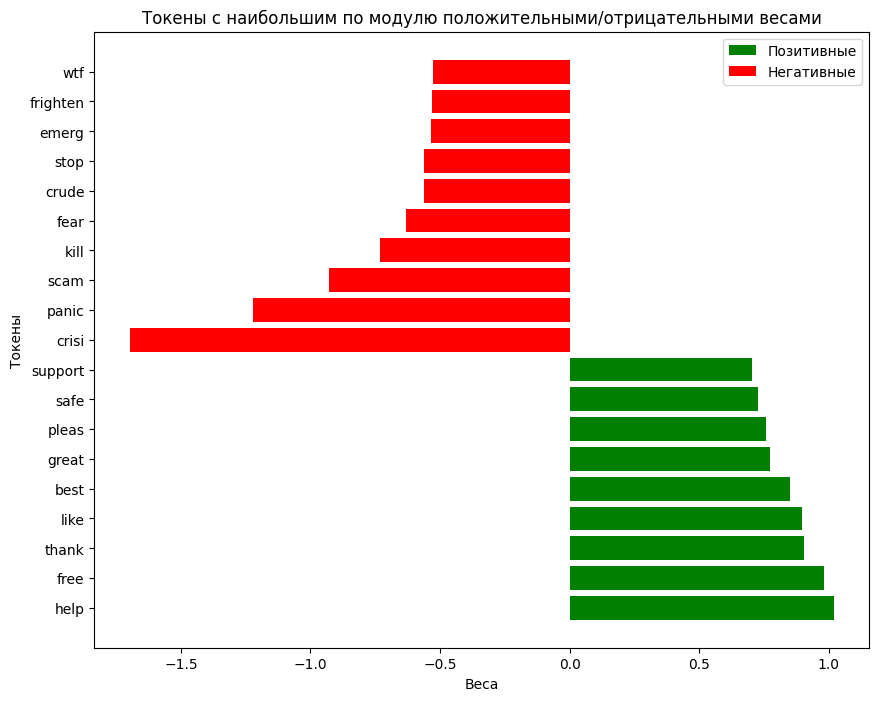

In [133]:
feature_names = cv_df.get_feature_names_out()

coefs = clf.coef_[0]
sorted_coefs = np.argsort(coefs)

positive_ind = sorted_coefs[-10:-1][::-1]
negative_ind = sorted_coefs[0:10]

positive_coefs = coefs[positive_ind]
negative_coefs = coefs[negative_ind]

positive_features = feature_names[positive_ind]
negative_features = feature_names[negative_ind]

plt.figure(figsize=(10, 8))
plt.barh(y = positive_features, width = positive_coefs, color = 'green', label = 'Позитивные')
plt.barh(y = negative_features, width = negative_coefs, color = 'red', label = 'Негативные')
plt.xlabel('Веса')
plt.ylabel('Токены')
plt.title('Токены с наибольшим по модулю положительными/отрицательными весами')
plt.legend()
plt.show()

**Ответ:** качество на обучающей выборке повысилось, но на тестовой снизилось. токены с наибольшими по модулю весами соответсвуют своей эмоциальной окраске, модель хорошо справилась с определением весов, на основе этих токенов можно предсказывать эмоциональную окраску

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [134]:
print(df['UserName'].nunique() == len(df['UserName']))
print(df['ScreenName'].nunique() == len(df['ScreenName']))

True
True


**Ответ:** признаки "имя пользователя" и "отображающееся имя пользователя" являются бесполезными, так как содержат только уникальные значения. если бы один человек оставлял много комментариев, данный признак возможно мог бы быть полезен (человек в основном пишет позитивные/негативные комментарии)



Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

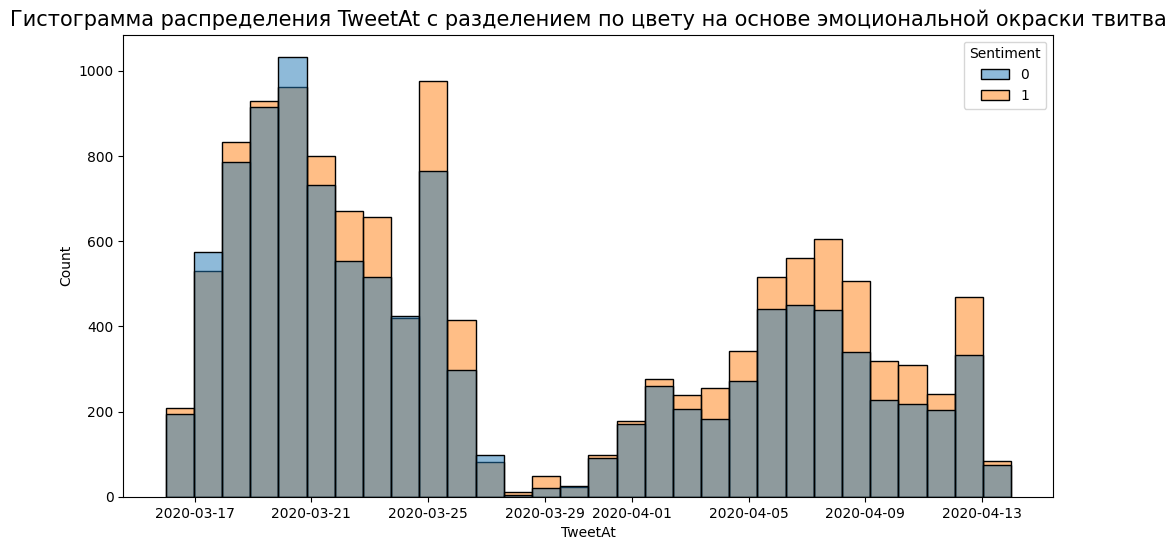

In [135]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Гистограмма распределения TweetAt с разделением по цвету на основе эмоциональной окраски твитва', fontsize=15)
sns.histplot(data=train,
             x='TweetAt',
             hue='Sentiment',
             bins=30,
             ax=ax);

**Ответ:** по гистограмме можно заметить, что положительных комментариев обычно немного больше в большинстве дней, существенной разницы в распределении эмоциональной окраски в зависимости от даты нет, поэтому нет смысла использовать данный признак в нашей модели. если бы в разные дни сущсетвенно преобладали твиты с разной эмоциональной окраской, то этот признак можно было бы включить в нашу модель



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [136]:
print('Количество уникальных значений:', train['Location'].nunique())
print('Всего твитов:', len(train['Location']))

Количество уникальных значений: 7949
Всего твитов: 23410


слишком много уникальных значений для того, чтобы анализировать данный признак

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

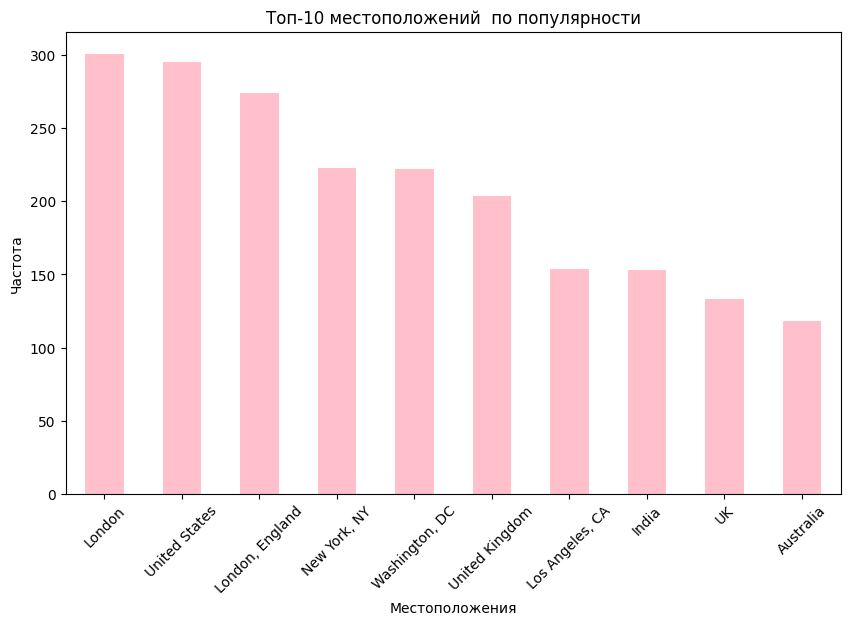

In [137]:
top_locations = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='pink')
plt.title('Топ-10 местоположений  по популярности')
plt.xlabel('Местоположения')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [138]:
wider_loc = []
for loc in train['Location']:
  last = loc.split(',')[-1]
  if last.split(' ')[-1] == '':
    wider_loc.append(last)
  else:
    wider_loc.append(last.split(' ')[-1])
train['WiderLocation'] = wider_loc
print('Количество уникальных значений:', len(train['WiderLocation'].unique()))

Количество уникальных значений: 3410


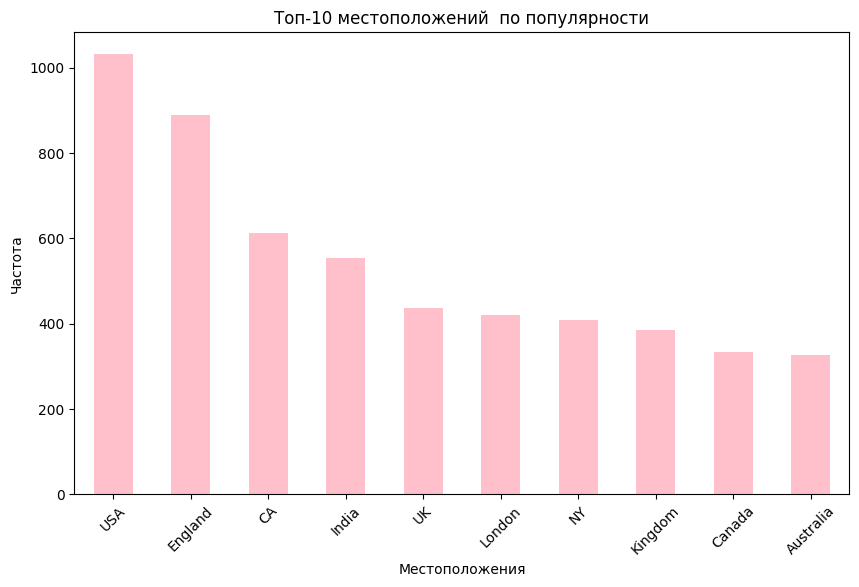

In [139]:
top_locations = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='pink')
plt.title('Топ-10 местоположений  по популярности')
plt.xlabel('Местоположения')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [140]:
top_locations = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts()
common_locations = top_locations[top_locations > 1].index.tolist()
print('Число местоположений, которые встречаются более одного раза в тренировочной выборке:', len(common_locations))

Число местоположений, которые встречаются более одного раза в тренировочной выборке: 976


In [141]:
wider_loc = []
for loc in df['Location']:
  last = loc.split(',')[-1]
  if last.split(' ')[-1] == '':
    wider_loc.append(last)
  else:
    wider_loc.append(last.split(' ')[-1])
df['WiderLocation'] = wider_loc
print('Количество уникальных значений во всем датасете:', len(df['WiderLocation'].unique()))

Количество уникальных значений во всем датасете: 4399


In [142]:
top_locations = df[df['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts()
common_locations = top_locations[top_locations > 1].index.tolist()
print('Число местоположений, которые встречаются более одного раза во всем датасете:', len(common_locations))

Число местоположений, которые встречаются более одного раза во всем датасете: 1265


датасет, в котором все WiderLocation встречаются более 1 раза

In [143]:
new_df = df[df['WiderLocation'].isin(common_locations)]
new_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1,UK
6,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,1,USA
8,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",1,Canada
10,3812,48764,"Chicago, IL",16-03-2020,"Me: I don't need to stock up on food, I'll jus...",1,IL
12,3814,48766,"Houston, Texas",16-03-2020,Lines at the grocery store have been unpredict...,1,Texas
...,...,...,...,...,...,...,...
33434,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York C...,1,NY
33435,44945,89897,"Gurgaon, India",14-04-2020,#Gold prices rose to a more than 7-year high t...,1,India
33436,44946,89898,"Brooklyn, NY",14-04-2020,YÃÂall really shitting that much more at hom...,0,NY
33438,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,0,Ontario


In [144]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[common_locations], sparse=False)
wider_location_ohe = encoder.fit_transform(new_df['WiderLocation'].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [146]:
df_ohe = pd.DataFrame(wider_location_ohe, columns = new_df['WiderLocation'].unique())
df_ohe

,UK,USA,Canada,IL,Texas,America,CO,centre,London,Idaho,...,Pender,Guelph.,Intelligence,Melbourne,BÃÂ©lgica,42,Tamilnadu,Lima-PerÃÂº,Abu Dhabi.,Ocea
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23251,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23252,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23253,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [147]:
for i in df_ohe.columns:
  df[i] = (df['WiderLocation'] == i)

<ipython-input-147-1476b7c33e7b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = (df['WiderLocation'] == i)
<ipython-input-147-1476b7c33e7b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = (df['WiderLocation'] == i)
<ipython-input-147-1476b7c33e7b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation,UK,USA,Canada,...,Pender,Guelph.,Intelligence,Melbourne,BÃÂ©lgica,42,Tamilnadu,Lima-PerÃÂº,Abu Dhabi.,Ocea
0,3800,48752,False,16-03-2020,advice Talk to your neighbours family to excha...,1,UK,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3801,48753,False,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1,Vagabonds,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3802,48754,False,16-03-2020,My food stock is not the only one which is emp...,1,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3803,48755,False,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3804,48756,False,16-03-2020,As news of the regionÃÂs first confirmed COV...,1,-82.363649,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33439,44949,89901,False,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1,OHIO,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33440,44950,89902,False,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33441,44952,89904,False,14-04-2020,Response to complaint not provided citing COVI...,0,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33442,44953,89905,False,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [148]:
df.drop(columns = 'WiderLocation', inplace = True)

In [149]:
ohe_train, ohe_test = train_test_split(df.iloc[:,6:], test_size=0.3, random_state=0)

,UK,USA,Canada,IL,Texas,America,CO,centre,London,Idaho,...,Pender,Guelph.,Intelligence,Melbourne,BÃÂ©lgica,42,Tamilnadu,Lima-PerÃÂº,Abu Dhabi.,Ocea
25621,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30135,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28899,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5989,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32103,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30403,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [150]:
bow_df_no_ohe_train = pd.DataFrame(bow_cv_df_train.toarray(), columns=cv_df.get_feature_names_out())
bow_df_ohe_train = np.concatenate((bow_df_no_ohe_train, ohe_train), axis=1)

In [151]:
bow_df_no_ohe_test = pd.DataFrame(bow_cv_df_test.toarray(), columns=cv_df.get_feature_names_out())
bow_df_ohe_test = np.concatenate((bow_df_no_ohe_test, ohe_test), axis=1)

In [155]:
clf_loc = LogisticRegression(max_iter=400, random_state=0)
clf_loc.fit(bow_df_ohe_train, y_train)
pred_train_loc = clf_loc.predict(bow_df_ohe_train)
pred_test_loc = clf_loc.predict(bow_df_ohe_test)
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_train_loc))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_test_loc))

Доля правильных ответов на обучающих данных: 0.9435284066638189
Доля правильных ответов на тестовых данных: 0.8427347020131553


**Ответ:** доля верных ответов увеличилась, но на тестовых данных совсем незначительно (0,03%). признак явояется не очень ваджным

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [156]:
best_cv = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8500)
bow_train_best = best_cv.fit_transform(train['OriginalTweet'])
bow_test_best = best_cv.transform(test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [171]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=123)
dt.fit(bow_train_best, y_train)
pred_train_dt = dt.predict(bow_train_best)
pred_test_dt = dt.predict(bow_test_best)
print('Доля правильных ответов на обучающих данных:', accuracy_score(y_train, pred_train_dt))
print('Доля правильных ответов на тестовых данных:', accuracy_score(y_test, pred_test_dt))

Доля правильных ответов на обучающих данных: 1.0
Доля правильных ответов на тестовых данных: 0.7646003587801475


я пыталась по разному только хуже получается:(